In [1]:
# Load data

import os
import glob
import h5py
import json
import numpy as np
import datetime
from scipy.optimize import curve_fit
from tqdm import tqdm
import matplotlib
# matplotlib.use('TkAgg')  # Set the interactive backend
import matplotlib.pyplot as plt
import pickle

In [2]:
# Load the data from the pickle file and plot the results
import pickle

file_name_to_be_loaded = '250510_BlueMOT_TOF_Results_Data_241109_BlueToF.pkl'

# --- Load later without recomputing ---
with open(file_name_to_be_loaded, 'rb') as f:
    data = pickle.load(f)

In [8]:
# ENSURE EVERYONE IS IN SI UNITS (i.e. meters and seconds)

pixel_size_m = (1/0.58)*3.45/1000000  # how many m per pixel

sigma_x_list = []
sigma_x_uncertainty_list = []
sigma_y_list = []
sigma_y_uncertainty_list = []
for tof in data.keys():
    sigma_x_list.append(data[tof]['sigma_x']*pixel_size_m) # convert to um
    sigma_x_uncertainty_list.append(data[tof]['sigma_x_uncertainty']*pixel_size_m)
    sigma_y_list.append(data[tof]['sigma_y']*pixel_size_m) # convert to um
    sigma_y_uncertainty_list.append(data[tof]['sigma_y_uncertainty']*pixel_size_m)
tof_list = list(data.keys())

# Sort the lists by time of flight
sorted_indices = np.argsort(tof_list)
sigma_x_list = np.array(sigma_x_list)[sorted_indices]
sigma_x_uncertainty_list = np.array(sigma_x_uncertainty_list)[sorted_indices]
sigma_y_list = np.array(sigma_y_list)[sorted_indices]
sigma_y_uncertainty_list = np.array(sigma_y_uncertainty_list)[sorted_indices]
tof_list = np.array(tof_list)[sorted_indices]

# Now fit the sigma_x and sigma_y to a function of time of flight

# Constants
m = 88*1.66e-27 # mass of Sr88 in kg
kB = 1.38e-23 # Boltzmann constant in J/K

# equation for tof is sigma_t^2 = (kB*T/m)*t^2 + sigma_0^2
# equating this to y=mx+c, we have:
    # y = sigma_t^2
    # slope m = kB*T/m
    # x = t^2
    # c = sigma_0^2

sigma_x_squared_list = np.array(sigma_x_list)**2
sigma_y_squared_list = np.array(sigma_y_list)**2
tof_squared_list = np.array(tof_list)**2

# uncertainties
sigma_x_squared_uncertainty_list = 2 * np.array(sigma_x_list) * np.array(sigma_x_uncertainty_list)
sigma_y_squared_uncertainty_list = 2 * np.array(sigma_y_list) * np.array(sigma_y_uncertainty_list)

# Fit the data to the equation
def linear_func(x, m, c):
    return m * x + c #y = mx + c

### ----------------------------------- DATA CLEANING START ---------------------------------- ###
# remove the last 9 points from all lists
index_to_remove = -10
sigma_x_squared_list = sigma_x_squared_list[:index_to_remove]
sigma_x_squared_uncertainty_list = sigma_x_squared_uncertainty_list[:index_to_remove]
sigma_y_squared_list = sigma_y_squared_list[:index_to_remove]
sigma_y_squared_uncertainty_list = sigma_y_squared_uncertainty_list[:index_to_remove]
tof_squared_list = tof_squared_list[:index_to_remove]
### ----------------------------------- DATA CLEANING END ---------------------------------- ###

# Fit the data taking into account the uncertainties
popt_x, pcov_x = curve_fit(linear_func, tof_squared_list, sigma_x_squared_list, sigma=sigma_x_squared_uncertainty_list)
popt_y, pcov_y = curve_fit(linear_func, tof_squared_list, sigma_y_squared_list, sigma=sigma_y_squared_uncertainty_list)

# Extract the parameters
slope_x, intercept_x = popt_x
slope_y, intercept_y = popt_y

# Calculate the temperature
temperature_x = slope_x * m / kB
temperature_y = slope_y * m / kB
temperature_x_uncertainty = np.sqrt(np.diag(pcov_x)[0]) * m / kB
temperature_y_uncertainty = np.sqrt(np.diag(pcov_y)[0]) * m / kB

print(f"Temperature from sigma_x: {temperature_x*1e3:.2f} ± {temperature_x_uncertainty*1e3:.2f} mK")
print(f"Temperature from sigma_y: {temperature_y*1e3:.2f} ± {temperature_y_uncertainty*1e3:.2f} mK")

Temperature from sigma_x: 4.72 ± 0.32 mK
Temperature from sigma_y: 4.32 ± 0.54 mK


# 250510 Plot one TOF fit

In [6]:
# copy paste this code to the beginning of your script to set the plotting style for a one column figure

from matplotlib import pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "figure.constrained_layout.use": True
})

plt.rcParams["savefig.bbox"] = None
plt.rcParams["figure.figsize"] = (5.9,2.5)  # (width, height) in inches, change height but not width
plt.rcParams["figure.titlesize"] = 10 # this is only for plt.suptitle, i set it to be the same as the rest

plt.rcParams["axes.titlesize"] = 10 # control title size
plt.rcParams["axes.labelsize"] = 10 # control x and y axis labels
plt.rcParams["axes.labelpad"] = 4.0 # distance between axis label and axis numbers
plt.rcParams["xtick.labelsize"] = 10 # independent control of xlabel fontsize
plt.rcParams["ytick.labelsize"] = 10 # independent control of ylabel fontsize

plt.rcParams["legend.fontsize"] = 7.5 # control legend size, I set it to be slightly smaller than title/axes label
# plt.rcParams["legend.facecolor"] = (0.9, 0.9, 0.9) # legend background color
# plt.rcParams["legend.edgecolor"] = (0, 0, 0) # legend border line color
# plt.rcParams["legend.frameon"] = True # whether or not to draw a border around legend
# plt.rcParams["legend.framealpha"] = 0.1 # legend background transparency
plt.rcParams["legend.loc"] = "best" # default legend location
plt.rcParams["legend.handletextpad"] = 0.8  # Horizontal space between legend point and text (default 0.8)
plt.rcParams["legend.labelspacing"] = 0.6  # Vertical space between legend entries (default 0.5)
# plt.rcParams["legend.columnspacing"] = 2.0  # Space between columns in multi-column legends
# plt.rcParams["legend.borderpad"] = 1.0  # Space between legend content and the box
# plt.rcParams["legend.handlelength"] = 2.0  # Length of legend marker lines

plt.rcParams["lines.linewidth"] = 1
plt.rcParams["lines.markersize"] = 6 #data point size

# CHOOSE NICE COLOR FOR DARK MARKER EDGEWIDTH FROM "dodgerblue","mediumseagreen","crimson","mediumpurple","slateblue","darkorange","peru","goldenrod"
plt.rcParams["lines.linewidth"] = 1
plt.rcParams["lines.markersize"] = 6 #data point size
plt.rcParams["lines.markeredgewidth"] = 1.5 # width of the edge of the marker
plt.rcParams["lines.markeredgecolor"] = "black" # color of the edge of the marker
plt.rcParams["lines.markerfacecolor"] = "dodgerblue" # color of the inside of the marker
plt.rcParams["lines.marker"] = "o" # marker type, see https://matplotlib.org/stable/api/markers_api.html for all options
plt.rcParams["lines.color"] = "black" # color of the line
# CHOOSE NICE COLOR FOR DARK MARKER EDGEWIDTH FROM "dodgerblue","mediumseagreen","crimson","mediumpurple","slateblue","darkorange","peru","goldenrod"


plt.rcParams["grid.linestyle"] = "--"
plt.rcParams['axes.grid'] = True
# plt.rcParams["grid.linewidth"] = 0.7

# plt.rcParams["xtick.major.pad"] = 4.0 # distance between xticks dashes and xaxis numbers
# plt.rcParams["xtick.major.size"] = 3.0
# plt.rcParams["xtick.major.width"] = 0.7
# plt.rcParams["ytick.major.pad"] = 4.0 # distance between yticks dashes and yaxis numbers
# plt.rcParams["ytick.major.size"] = 3.0
# plt.rcParams["ytick.major.width"] = 0.7

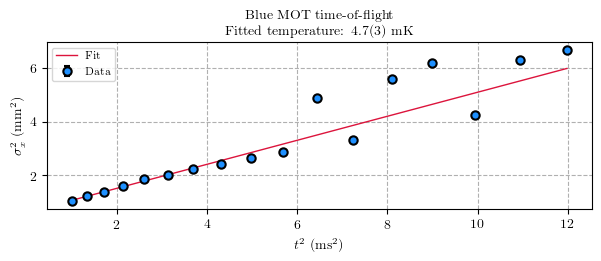

In [14]:
plt.errorbar(tof_squared_list*1e6, sigma_x_squared_list*1e6, yerr=sigma_x_squared_uncertainty_list, fmt='o', ecolor='black',capsize=2,label='Data')
plt.plot(tof_squared_list*1e6, linear_func(tof_squared_list, *popt_x)*1e6, '-', color='crimson', label='Fit')
plt.xlabel(r'$t^2$ (ms$^2$)')
plt.ylabel(r'$\sigma_x^2$ (mm$^2$)')
plt.title(r'Blue MOT time-of-flight' + '\n' + r'Fitted temperature: ' + f'{temperature_x*1e3:.1f}({temperature_x_uncertainty*1e4:.0f}) mK')
plt.legend()

plt.savefig("250510 BlueMOTToFFitResults.pdf", dpi=300)

# 250510 Also plot fluoerscence images of the cloud as it is dropping, using tof1 data

In [46]:
# copy paste this code to the beginning of your script to set the plotting style for a two column figure

from matplotlib import pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    # "figure.constrained_layout.use": True
})

plt.rcParams["figure.autolayout"] = False # set to True if you want to use constrained_layout

plt.rcParams["savefig.bbox"] = None
plt.rcParams["figure.figsize"] = (5.9,3)
plt.rcParams["figure.titlesize"] = 10 # this is only for plt.suptitle, i set it to be the same as the rest

plt.rcParams["axes.titlesize"] = 10 # control title size
plt.rcParams["axes.labelsize"] = 10 # control x and y axis labels
plt.rcParams["axes.labelpad"] = 4.0 # distance between axis label and axis numbers
plt.rcParams["xtick.labelsize"] = 10 # independent control of xlabel fontsize
plt.rcParams["ytick.labelsize"] = 10 # independent control of ylabel fontsize

plt.rcParams["legend.fontsize"] = 7.5 # control legend size, I set it to be slightly smaller than title/axes label
# plt.rcParams["legend.facecolor"] = (0.9, 0.9, 0.9) # legend background color
# plt.rcParams["legend.edgecolor"] = (0, 0, 0) # legend border line color
# plt.rcParams["legend.frameon"] = True # whether or not to draw a border around legend
# plt.rcParams["legend.framealpha"] = 0.1 # legend background transparency
plt.rcParams["legend.loc"] = "upper left" # default legend location
plt.rcParams["legend.handletextpad"] = 0.8  # Horizontal space between legend point and text (default 0.8)
plt.rcParams["legend.labelspacing"] = 0.6  # Vertical space between legend entries (default 0.5)
# plt.rcParams["legend.columnspacing"] = 2.0  # Space between columns in multi-column legends
# plt.rcParams["legend.borderpad"] = 1.0  # Space between legend content and the box
# plt.rcParams["legend.handlelength"] = 2.0  # Length of legend marker lines

plt.rcParams["lines.linewidth"] = 1
# plt.rcParams["lines.markeredgewidth"] = 0.7
plt.rcParams["lines.markersize"] = 4 #data point size

plt.rcParams["grid.linestyle"] = "--"
plt.rcParams['axes.grid'] = False
# plt.rcParams["grid.linewidth"] = 0.7

# plt.rcParams["xtick.major.pad"] = 4.0 # distance between xticks dashes and xaxis numbers
# plt.rcParams["xtick.major.size"] = 3.0
# plt.rcParams["xtick.major.width"] = 0.7
plt.rcParams["ytick.major.pad"] = 4.0 # distance between yticks dashes and yaxis numbers
# plt.rcParams["ytick.major.size"] = 3.0
# plt.rcParams["ytick.major.width"] = 0.7

In [27]:
file_path = r"/Volumes/MBQD_data/AION/Data/2024/09/11/blue_tof"

# Get a list of all HDF5 files in the directory
h5_files = glob.glob(os.path.join(file_path, '*.h5'))

horizontal_camera_MOT_image_list = []
vertical_camera_MOT_image_list = []
time_of_flight_list = []

for file_path in h5_files:
    with h5py.File(file_path, 'r') as h5file:
        time_of_flight = json.loads(h5file['parameters'][()])["sequence_parameters"]["time_of_flight"]
        horizontal_camera_MOT_image = h5file['horizontal camera red mot'][:]
        vertical_camera_MOT_image = h5file['vertical camera red mot'][:]
    if np.sum(horizontal_camera_MOT_image) > 1e5 or np.sum(vertical_camera_MOT_image) > 1e5:
        horizontal_camera_MOT_image_list.append(horizontal_camera_MOT_image)
        vertical_camera_MOT_image_list.append(vertical_camera_MOT_image)
        time_of_flight_list.append(time_of_flight)

# Convert the lists to numpy arrays and sort them by time of flight
horizontal_camera_MOT_image_list = np.array(horizontal_camera_MOT_image_list)
vertical_camera_MOT_image_list = np.array(vertical_camera_MOT_image_list)
time_of_flight_list = np.array(time_of_flight_list)
sorted_indices = np.argsort(time_of_flight_list)
horizontal_camera_MOT_image_list = horizontal_camera_MOT_image_list[sorted_indices]
vertical_camera_MOT_image_list = vertical_camera_MOT_image_list[sorted_indices]
time_of_flight_list = time_of_flight_list[sorted_indices]


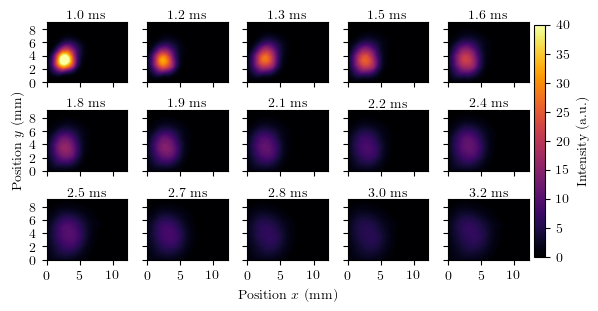

In [54]:

fig, axes = plt.subplots(3, 5, sharex=True, sharey=True, constrained_layout=True)

pixel_size_um = (1/0.58)*3.45/1000  # how many mm per pixel

extent = [0, horizontal_camera_MOT_image_list[0].shape[1]*pixel_size_um,  # x-axis: 0 to 1200 * 5
          0, horizontal_camera_MOT_image_list[0].shape[0]*pixel_size_um]  # y-axis: 0 to 1200 * 5

for i, ax in enumerate(axes.flatten()):
    if i < len(horizontal_camera_MOT_image_list):
        im = ax.imshow(horizontal_camera_MOT_image_list[i],cmap='inferno',vmin=0,vmax=40,origin='lower',extent=extent)
        ax.set_title(f'{round(time_of_flight_list[i]*1000,1)} ms',pad=2)
        ax.set_yticks([0,2,4,6,8])
        ax.set_yticklabels([0,2,4,6,8])
        ax.set_xticks([0, 5, 10])
        ax.set_xticklabels([0, 5, 10])
        

axes[1,0].set_ylabel(r"Position $y$ (mm)")
axes[2,2].set_xlabel(r"Position $x$ (mm)")

# fig.text(-0.03, 0.5, r'Position $y$ (mm)', va='center', rotation='vertical')

cbar = fig.colorbar(im, ax=axes, shrink=0.975, pad=0.01)
cbar.set_label(r"Intensity (a.u.)")

plt.savefig("250510 BlueMOTToFFluorescenceImages.pdf", dpi=300)

In [21]:
enumerate(axes.flatten())